# TNG Playground

This notebook serves as a sandbox, set up for easy access to TNG data. It is used to quickly load TNG simulation data, play round with it, determine quantities etc. 

## Set-up

Setting up the Python env

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# IMPORTS
import h5py
import logging
import logging.config
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from pathlib import Path

import illustris_python as il

Importing helper scripts

In [4]:
# import the helper scripts
module_path = Path(os.getcwd()) / ".." / "src"
sys.path.append(str(module_path.resolve()))
from library.config import logging_config, config
from library.processing import selection
from library.data_acquisition import halos_daq
from library import constants

Set up a small logging environment for impromptu logging during lengthy operations:

In [5]:
logging_cfg = logging_config.get_logging_config("INFO")
logging.config.dictConfig(logging_cfg)
logger = logging.getLogger("root")
# test setup
logger.info("I am a test log!")

INFO: I am a test log!


Define some globals that point to different simulations:

In [6]:
TEST_SIM = "TNG50-4"
DEV_SIM = "TNG300-2"
MAIN_SIM = "TNG300-1"
CLUSTER = "TNG-Cluster"

## Probing plots

Firstly, the distribution of masses in the simulation should be probed to get an idea of how to best bin the halos by mass.

In [6]:
def plot_halo_mass_distribution() -> float:
    """Plot the mass distribution of halos in TNG300-1"""
    logger.info("Loading halo mass data.")
    cfg = config.get_default_config(MAIN_SIM)
    masses = il.groupcat.loadHalos(
        cfg.base_path, cfg.snap_num, fields=cfg.mass_field
    )
    # adjust for units
    masses = masses * 1e10 / constants.HUBBLE

    max_mass = np.max(masses)

    # plot hist of masses in log scale
    logger.info("Plotting histrogram.")
    fig, axes = plt.subplots(figsize=(5, 5))
    axes.set_xlabel(r"Masses ($M_{Crit, 200}$) [$\log M_\odot$]")
    axes.set_ylabel("Count")
    axes.set_title("Mass distribution in TNG300-1")
    plot_config = {
        "bins": 40,
        "histtype": "stepfilled",
        "log": False,
        "edgecolor": "black",
        "facecolor": "crimson",
    }
    # plot only the log and exclude masses near zero
    axes.hist(np.log10(masses[(masses > 1)]), **plot_config)
    # add info on min and max mass
    axes.text(11.8, 2e5, rf"Max mass: ${max_mass:.2e} M_\odot$")
    return max_mass


INFO: Loading halo mass data.


INFO: Plotting histrogram.


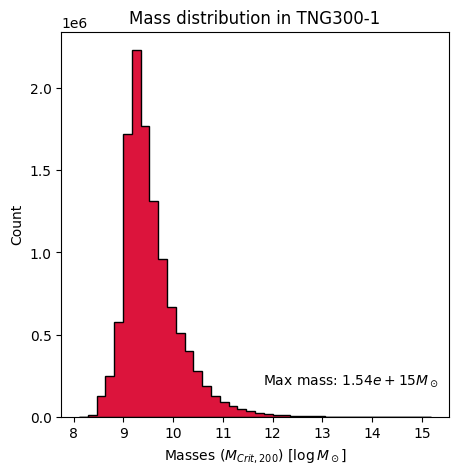

In [7]:
plot_halo_mass_distribution()

Judging by this, it is sensible to consider masses ranging from $10^8 M_\odot$ up to around $10^{15} M_\odot$, but given the fact that an overwhelming majority of halos have masses between $10^8 M_\odot$ and $10^{12} M_\odot$, it might be advisable to exclude very high mass bins in the beginning and only consider them for plots of individual halo temperature distributions.

We do a similar plot for the virial radii for completeness:

In [16]:
def plot_halo_radial_distribution() -> float:
    """Plot the mass distribution of halos in TNG300-1"""
    logger.info("Loading halo mass data.")
    cfg = config.get_default_config(MAIN_SIM)
    radii = il.groupcat.loadHalos(
        cfg.base_path, cfg.snap_num, fields=cfg.radius_field
    )
    # adjust for units
    radii = radii / constants.HUBBLE

    max_radius = np.max(radii)

    # plot hist of masses in log scale
    logger.info("Plotting histrogram.")
    fig, axes = plt.subplots(figsize=(5, 5))
    axes.set_xlabel(r"Radius ($R_{Crit, 200}$) [$kpc$]")
    axes.set_ylabel("Count")
    axes.set_title("Radial distribution in TNG300-1")
    plot_config = {
        "bins": 40,
        "histtype": "stepfilled",
        "log": False,
        "edgecolor": "black",
        "facecolor": "teal",
    }
    # plot only the log and exclude masses near zero
    axes.hist(np.log10(radii[(radii > 1)]), **plot_config)
    # add info on min and max mass
    axes.text(1.9, 5e5, rf"Max radius: ${max_radius:.2e} \ \log_{{10}} kpc$")
    return max_radius

INFO: Loading halo mass data.


INFO: Plotting histrogram.


2432.7222

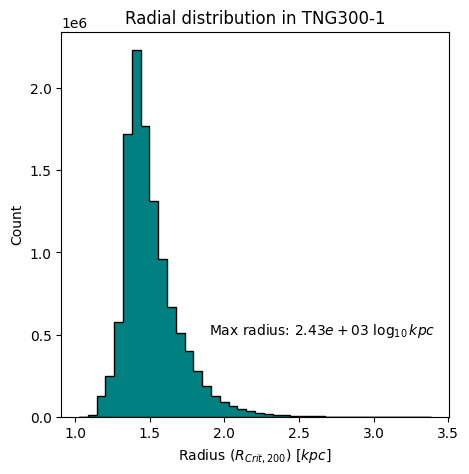

In [17]:
plot_halo_radial_distribution()

## Exploring data format

We wish to explore the numeric format of gas data fields, as they are not explicitly given in the data specification (as opposed to group data, which has this information added).

In [8]:
def show_particle_field_format() -> None:
    """ 
    Print the type of various data fields of gas data from TNG300-1.
    """
    fields = [
        "InternalEnergy", "ElectronAbundance", "Masses", "StarFormationRate", "Coordinates"
    ]
    cfg = config.get_default_config(MAIN_SIM)
    gas_data = il.snapshot.loadHalo(
        cfg.base_path, cfg.snap_num, id=2000, partType=0, fields=fields
    )
    for field in fields:
        print(f"Type of {field}: {gas_data[field].dtype}")

In [9]:
show_particle_field_format()

Type of InternalEnergy: float32
Type of ElectronAbundance: float32
Type of Masses: float32
Type of StarFormationRate: float32
Type of Coordinates: float64


## File size estimates

### Saving histograms for every halo of TNG300-1

Estimating how much space on disk it would take to save histograms of all halos in TNG300-1 to file. Every histogram is a numpy array of size (50,) and of data type float32. This means that the total array will occupy $N \cdot 50 \cdot 32 \ \text{bytes}$ on disk, where $N$ is the number of halos in TNG300-1. We can easily find the total file size then as follows:

In [10]:
def estimate_file_size_for_hists() -> float:
    """
    Return file size for histogram data saved to file in MB.
    """
    NUM_BINS = 50
    cfg = config.get_default_config(MAIN_SIM)
    f = h5py.File(il.groupcat.gcPath(cfg.base_path, cfg.snap_num, 0), 'r')
    n_groups = f["Header"].attrs["Ngroups_Total"]
    f.close()
    print(f"Total number of halos: {n_groups:,.0f}")
    # calculate file size
    size = sys.getsizeof(np.zeros(NUM_BINS, dtype="float32"))
    file_size_in_bytes = size * n_groups
    return file_size_in_bytes / 1024. / 1024.

In [11]:
filesize = estimate_file_size_for_hists()
print(f"Estimated size on disk: {filesize:.2f} MB")

Total number of halos: 17,625,892
Estimated size on disk: 5244.52 MB


### Loading four fields for every gas particle in TNG300-1

Similarly, we want to estimate how much space in memory it will take up to load four fields of all particles in TNG300-1. This is useful as temperature is calculated with three quantities: internal energy, electron abundance and star formation rate. This means that in order to calculate temperature, four fields will be loaded.

In [11]:
def estimate_memory_size_for_particle_data() -> float:
    """
    Return size in memory for gas data with four fields in GB.
    """
    NUM_FIELDS = 4
    cfg = config.get_default_config(MAIN_SIM)
    f = h5py.File(il.snapshot.snapPath(cfg.base_path, cfg.snap_num, 0), 'r')
    n_part = f["Header"].attrs["NumPart_Total"][0]
    n_part += f["Header"].attrs["NumPart_Total_HighWord"][0] * 2**32
    print(f"Total number of gas particles: {n_part:,}")
    f.close()
    size = sys.getsizeof(np.zeros(n_part, dtype="float32"))
    memsize = NUM_FIELDS * size
    return memsize / 1024. / 1024. / 1024.

In [12]:
memsize = estimate_memory_size_for_particle_data()
print(f"Estimated size in memory: {memsize:.4f} GB")

Total number of gas particles: 14,454,722,210
Estimated size in memory: 215.3921 GB


#### Accounting for multiprocessing

If we now also assume that we wish to calculate the temperature in parallel from these quantities, that gives us a number of $p$ processes, which means the memory size is duplicated by a factor of $p$. We want to find how many processes we can afford on the 250 GB, 500 GB and 1 TB nodes respectively.

We also have to take into account the mass and ID data for the halos that are selected prior to the loading of gas data. We can assume there to be 280 halos in TNG300-1, every one of which has an int32 ID and a float32 mass, meaning they take up $280(32 + 32) = 17.5 kB$. That is pretty much negligible. 

We thus have $p_{max} = M_{node} / M_{part}$, where $M$ is the memory capacity of the node and the memory requirement for the particle data. 

In [13]:
def estimate_processes_per_node(node_cap: float) -> float:
    """ 
    Estimate the number of processes the given node can support.

    :param node_cap: memory capacity of the node in GB.
    """
    memory_req = estimate_memory_size_for_particle_data()  # in GB
    return node_cap / memory_req

In [14]:
print(f"p.vera supports {estimate_processes_per_node(250)} processes.")
print(f"p.large supports {estimate_processes_per_node(500)} processes.")
print(f"p.huge supports {estimate_processes_per_node(1000)} processes.")

Total number of gas particles: 14,454,722,210
p.vera supports 1.1606737039812773 processes.
Total number of gas particles: 14,454,722,210
p.large supports 2.3213474079625547 processes.
Total number of gas particles: 14,454,722,210
p.huge supports 4.642694815925109 processes.


We see that we cannot use the nodes to their full extent. Accounting for other memory requirments such as temporary memory allocation, pipeline objects and the halo data, a safe estimate seems to be:

- p.vera: 9-10 processes
- p.large: ~20 processes
- p.huge: 40-42 processes

### Size in memory of a 50x50 2D histogram

Finally, we want to know the size in memory for 50 x 50 2D histograms with float32 values:

In [15]:
def estimate_file_size_for_2dhists() -> float:
    """
    Return file size for histogram data saved to file in MB.
    """
    EDGE_LENGTH = 50
    cfg = config.get_default_config(MAIN_SIM)
    f = h5py.File(il.groupcat.gcPath(cfg.base_path, cfg.snap_num, 0), 'r')
    n_groups = f["Header"].attrs["Ngroups_Total"]
    f.close()
    print(f"Total number of halos: {n_groups:,.0f}")
    # calculate file size
    size = sys.getsizeof(np.ones((EDGE_LENGTH, EDGE_LENGTH), dtype="float32"))
    file_size_in_bytes = size * n_groups
    return file_size_in_bytes / 1024. / 1024. / 1024.  # in GB

Since at any given time, the given number of processes will also load halo gas data (which can take up a substantial part of memory), we need to take into account at least the largest halos and their gas data as well:

In [16]:
def estimate_maximum_memory_per_process() -> float:
    """
    Return size in memory of the gas cell data of the largest halo in TNG300-1.
    """
    NUMBER_FIELDS_32 = 4  # 4 base fields
    NUMBER_FIELDS_64 = 3  # plus 3 position values
    cfg = config.get_default_config(MAIN_SIM)
    halo_data = il.snapshot.loadHalo(
        cfg.base_path, cfg.snap_num, id=0, partType=0, fields=["InternalEnergy"]
    )
    field_size = sys.getsizeof(halo_data)  # in bytes
    print(f"Number of gas cells in largest halo: {len(halo_data):,.0f}.")
    # calculate size in memory
    memory = NUMBER_FIELDS_32 * field_size + NUMBER_FIELDS_64 * field_size * 2
    return memory / 1024. / 1024. / 1024.  # in GB 

In [17]:
histsize = estimate_file_size_for_2dhists()
max_mem = estimate_maximum_memory_per_process()
print(f"Estimated size in memory: {histsize:.4f} GB")
print(f"Size of gas cells for largest halo: {max_mem:.4f} GB")
print(f"Estimated additional memory @72 processes: {72 * max_mem / 2:.4f} GB")
print(f"\nTOTAL: {histsize + 72 * max_mem / 2:.2f} GB")

Total number of halos: 17,625,892
Number of gas cells in largest halo: 31,423,633.
Estimated size in memory: 166.2551 GB
Size of gas cells for largest halo: 1.1706 GB
Estimated additional memory @72 processes: 42.1424 GB

TOTAL: 208.40 GB


This, with the additional halo data, is already be enough to fill all memory on a standard computation node: the halo data consists of 5 fields (mass, radius, position coordinates) which equals $5 \cdot 32 B \cdot 17,625,892 = 2.6264 GB$ of halo data. Since this data is copied into every process, this leads to a total halo data memory allocation of $2.6 GB \cdot 72 = 189 GB$. 

This leads to a grand total of $\sim 397 GB$ of maximally used memory.

A 500GB node seems to be the only option here; perhaps a 1TB node may even become necessary.

## Exploring offsets

Here we want to understand how offset files work: what do offsets loaded with `il.snapshot.getSnapOffsets` look like, what do the individual offsets reprsent and most importantly: which offset gives us the first particle ID in a FoF group.

In [19]:
def explore_offsets() -> dict:
    cfg = config.get_default_config(MAIN_SIM)
    offsets = il.snapshot.getSnapOffsets(cfg.base_path, cfg.snap_num, 28364, "Group")
    print(f"Shape of 'snapOffsets': {offsets['snapOffsets'].shape}")
    print(f"Shape of 'lenType': {offsets['lenType'].shape}, type: {type(offsets['lenType'][0])}")
    print(f"Shape of 'offsetType': {offsets['offsetType'].shape}, type: {type(offsets['offsetType'][0])}")
    return offsets

In [20]:
%time explore_offsets()

Shape of 'snapOffsets': (6, 600)
Shape of 'lenType': (6,), type: <class 'numpy.int32'>
Shape of 'offsetType': (6,), type: <class 'numpy.int64'>
CPU times: user 5.47 ms, sys: 0 ns, total: 5.47 ms
Wall time: 27.3 ms


{'snapOffsets': array([[          0,    23851047,    47762531, ..., 14382702488,
         14406373170, 14430545360],
        [          0,    25680412,    51322410, ..., 15546108263,
         15572641241, 15598828199],
        [          0,           0,           0, ...,           0,
                   0,           0],
        [          0,    27199194,    54194711, ..., 15531779586,
         15561116312, 15592723539],
        [          0,     1787650,     3494151, ...,   708520692,
           709748698,   710864666],
        [          0,        1103,        2201, ...,      697660,
              698785,      699983]]),
 'lenType': array([ 8411, 30518,     0,     0,  4194,     2], dtype=int32),
 'offsetType': array([2488838398, 4775404601,          0,          0,  571438234,
            156918])}

It appears that `lenType` gives the number of particles per type in the given halo, while `offsetType` gives the index of the first particle of every type belonging to that halo. This way, one can get all particles of particle type `i` by slicing an array of all particles of type `i` using

```python
halo_particles = type_i_particles[offsets["offsetType"][i] : offsets["offsetType"][i] + offsets["lenType"][i]]
```

The `snapOffsets` are probably the offsets of the first particle of every type across all snapshots.

## Comparing virial temperature estimates

We have two virial temperature estimates that we want to compare: firstly, the virial temperature estimate from Nelson et al. (2013), which is based on Barkana & Loeb (2001) and which assumes a molecular mean weight of $\mu \sim 0.6$ and a virial radius fully determined by the mass:

$$T_{vir} \simeq 4 \cdot 10^5 \text{K} \left( \dfrac{M}{10^{11} h^{-1} M_\odot} \right)^\frac{2}{3} \left( \dfrac{1 + z}{3} \right)$$

Secondly, we have the estimate derived ourselves directly from the virial theorem, assuming the halo is virialized and the velocities within are thermal velocities, caused purely by the gravitational potential:

$$T_{vir} \simeq \dfrac{2}{5} \dfrac{G M m_p}{R k_B}$$

We might wish to improve this relation by replacing the pure proton mass with the term $\mu m_p$ for more accuracy. This is (sans the pre-factor) equivalent to the formula for virial temperature in Barkana & Loeb (2001):

$$T_{vir} \simeq \dfrac{\mu m_p}{2k_B} \dfrac{GM}{R}$$

We now want to see how these compare.

In [21]:
def virial_temperature_nelson(mass: float) -> float:
    """Return virial temperature according to Nelson et al. (2013)"""
    return 4e5 * (mass / (1e11 * (constants.HUBBLE)**(-1)))**(2/3) / 3
                  

def virial_temperature_simple(mass: float, radius: float) -> float:
    """Return the virial temperature according to a simple estimate"""
    numerator = 2 * constants.G * constants.m_p * mass * constants.M_sol
    denominator = 5 * radius * constants.kpc * constants.k_B
    return numerator / denominator


def virial_temperature_barakana_loeb(mass: float, radius: float) -> float:
    """
    Return the virial temperature according to Barkana & Loeb (2002)
    """
    numerator = 0.6 * constants.m_p * constants.G * constants.M_sol * mass
    denominator = 2 * constants.k_B * constants.kpc * radius
    return numerator / denominator


def compare_virial_temperatures(halo_id: int) -> None:
    """
    Calculate halo virial temperature in three ways and print result

    :param halo_id: The halo ID of the halo to use.
    """
    cfg = config.get_default_config(MAIN_SIM)
    halo_data = il.groupcat.loadSingle(cfg.base_path, cfg.snap_num, haloID=halo_id)
    mass = halo_data[cfg.mass_field] * 1e10 / constants.HUBBLE
    radius = halo_data[cfg.radius_field] / constants.HUBBLE

    if radius == 0:
        print("Halo has no virial radius, skipping.")
        return

    # out put comparison
    print(f"Nelson: log T = {np.log10(virial_temperature_nelson(mass))}")
    print(f"Simple: log T = {np.log10(virial_temperature_simple(mass, radius))}")
    print(f"B&L: log T = {np.log10(virial_temperature_barakana_loeb(mass, radius))}")

In [22]:
print("Halo with ID 12:")
compare_virial_temperatures(12)
print("")

for _ in range(5): 
    id = np.random.randint(0, 17_000_000)
    print(f"Halo with ID {id}:")
    compare_virial_temperatures(id)
    print("")

Halo with ID 12:
Nelson: log T = 7.556409957182588
Simple: log T = 7.8725278666830665
B&L: log T = 7.747589130074766

Halo with ID 11621575:
Nelson: log T = 3.6425041935882088
Simple: log T = 3.9586291472903232
B&L: log T = 3.8336904106820233

Halo with ID 1756572:
Nelson: log T = 4.429856123873045
Simple: log T = 4.745967264795469
B&L: log T = 4.6210285281871695

Halo with ID 11019278:
Nelson: log T = 3.6995978690496414
Simple: log T = 4.015697872142057
B&L: log T = 3.8907591355337563

Halo with ID 2013071:
Nelson: log T = 4.378761821574531
Simple: log T = 4.6948640037766465
B&L: log T = 4.569925267168347

Halo with ID 2192470:
Nelson: log T = 4.282986179156656
Simple: log T = 4.599103422620775
B&L: log T = 4.474164686012475


We see that the estimation from Nelson (2013) is noticably smaller than the two other estimates. The difference between the last two values is explained by the different coeffcient, of course. 

## TNG-Cluster

We now want to understand how to use TNG-Cluster and how its files are organized. According to its documentation, it can be used just like the other three TNG simulations. Let;s test this by loading some classic halo properties:

In [16]:
def load_cluster_properties(fields: list) -> dict:
    """Load the given properties from TNG-Cluster"""
    cfg = config.get_default_config(CLUSTER)
    fields.append("GroupPrimaryZoomTarget")
    halo_data = il.groupcat.loadHalos(cfg.base_path, cfg.snap_num, fields = fields)
    return halo_data


def test_some_cluster_stuff() -> None:
    """Test some random stuff about TNG-Cluster"""
    fields = ["Group_M_Crit200", "GroupOrigHaloID"]
    halo_data = load_cluster_properties(fields)

    # test the number of halos
    print(f"Loaded {len(halo_data['Group_M_Crit200'])} halos.")

    # test what the IDs look like
    print(halo_data["GroupOrigHaloID"][:400])

    # count number of original zooms
    n_original_targets = np.count_nonzero(halo_data["GroupPrimaryZoomTarget"])
    print(f'Original zoom targets: {n_original_targets}')
    # IDs of zoom targets
    print(f"IDs of zoom targets: {np.nonzero(halo_data['GroupPrimaryZoomTarget'])}")
    # Original IDs of zoom targets
    origs = selection.mask_quantity(
        halo_data["GroupOrigHaloID"], 
        halo_data["GroupPrimaryZoomTarget"],
        index=1,
    )
    print(f"Original IDs of zoom-ins: {origs}")

In [17]:
test_some_cluster_stuff()

Loaded 19453039 halos.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Original zoom targets: 352
IDs of zoom targets: (array([       0,   252455,   476245,   692426,   880597,  1068507,
        1263653,  1431487,  1580995,  1763481,  1

We now also test the extended features of the `get_halo_properties` function:

In [26]:
def test_load_halo_func():
    cfg = config.get_default_config(CLUSTER)
    fields = [cfg.mass_field, cfg.radius_field]
    halo_data = halos_daq.get_halo_properties(
        cfg.base_path, cfg.snap_num, fields=fields, cluster_restrict=True
    )
    assert len(halo_data["IDs"] == 352)
    assert halo_data["count"] == 352
    # print(halo_data["IDs"])

    cfg = config.get_default_config(TEST_SIM)
    try:
        halo_data = halos_daq.get_halo_properties(
            cfg.base_path, cfg.snap_num, fields=fields, cluster_restrict=True
        )
    except KeyError as e:
        print(f"KeyError succesfully raised, yay!\n{str(e)}")

In [27]:
test_load_halo_func()

INFO: Loading halo properties ['Group_M_Crit200', 'Group_R_Crit200'].
INFO: Restricting halo data to original zoom-in clusters only.
INFO: Finished loading halo properties.
INFO: Loading halo properties ['Group_M_Crit200', 'Group_R_Crit200'].
INFO: Restricting halo data to original zoom-in clusters only.
CRITICAL: Attempted to restrict halo data for a simulation that is not TNG Cluster, exception will be raised.
KeyError succesfully raised, yay!
"The simulation group catalogue does not provide the field 'GroupPrimaryZoomTarget'."
